In [1]:
# =============================================================================
# CELL 1: Installation and Setup
# =============================================================================
"""
# 🎬 AI Storyboard Maker - Enhanced Edition

Transform your images into captivating stories with customizable moods!

## Features:
- Upload images and get AI captions
- Choose story mood (Romance, Comedy, Scary, Action, Cartoonish)
- Generate creative stories based on your captions

**Models used:**
- BLIP for image captioning
- Mistral-7B for creative story generation
"""

print("📦 Installing required packages...")
print("   This may take 1-2 minutes...")
!pip install -q transformers torch pillow accelerate sentencepiece bitsandbytes

print("✅ Installation complete!")

📦 Installing required packages...
   This may take 1-2 minutes...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 11.6 MB/s eta 0:00:00
✅ Installation complete!


In [2]:
# =============================================================================
# CELL 2: Import Libraries
# =============================================================================
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from PIL import Image
import io
from google.colab import files
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Markdown
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [3]:
# =============================================================================
# CELL 3: Load AI Models
# =============================================================================
print("🤖 Loading AI models... (This may take 2-3 minutes on first run)")
print("Models are cached for faster subsequent runs.")

# Load image captioning model
print("\n📸 Loading BLIP for image captioning...")
caption_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
caption_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Move to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
caption_model.to(device)
print(f"   ✓ BLIP loaded on {device.upper()}")

# Load story generation model - Using Gemma 2B (lightweight, creative, free!)
print("\n📖 Loading Gemma-2B for story generation...")
print("   This is a powerful creative writing model by Google")

# Quantization config for memory efficiency
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

story_model_name = "google/gemma-2b-it"
story_tokenizer = AutoTokenizer.from_pretrained(story_model_name)
story_model = AutoModelForCausalLM.from_pretrained(
    story_model_name,
    quantization_config=quantization_config if device == "cuda" else None,
    device_map="auto" if device == "cuda" else None,
    low_cpu_mem_usage=True
)

if device == "cpu":
    story_model.to(device)

print(f"   ✓ Gemma-2B loaded on {device.upper()}")
print("\n✅ All models loaded and ready!")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


🤖 Loading AI models... (This may take 2-3 minutes on first run)
Models are cached for faster subsequent runs.

📸 Loading BLIP for image captioning...


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

   ✓ BLIP loaded on CUDA

📖 Loading Gemma-2B for story generation...
   This is a powerful creative writing model by Google


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

   ✓ Gemma-2B loaded on CUDA

✅ All models loaded and ready!


In [4]:
# =============================================================================
# CELL 4: Define Helper Functions
# =============================================================================

# Story mood templates
MOOD_PROMPTS = {
    "romance": {
        "style": "romantic and heartfelt",
        "tone": "Write a tender, emotional love story",
        "elements": "Include themes of connection, longing, and emotional depth."
    },
    "comedy": {
        "style": "humorous and lighthearted",
        "tone": "Write a funny, entertaining story with witty moments",
        "elements": "Include comedic situations, amusing observations, and playful humor."
    },
    "scary": {
        "style": "dark and suspenseful",
        "tone": "Write a chilling, atmospheric horror story",
        "elements": "Build tension, include eerie details, and create a sense of dread."
    },
    "action": {
        "style": "intense and thrilling",
        "tone": "Write a fast-paced, adrenaline-pumping action story",
        "elements": "Include dynamic movement, high stakes, and exciting sequences."
    },
    "cartoonish": {
        "style": "whimsical and playful",
        "tone": "Write a fun, animated-style adventure story",
        "elements": "Use vibrant descriptions, exaggerated actions, and cheerful energy."
    }
}

def generate_caption(image):
    """Generate caption for a single image using BLIP"""
    inputs = caption_processor(image, return_tensors="pt").to(device)

    with torch.no_grad():
        out = caption_model.generate(**inputs, max_length=50, num_beams=3)

    caption = caption_processor.decode(out[0], skip_special_tokens=True)
    return caption

def display_image_with_caption(image, caption, scene_num):
    """Display an image with its caption"""
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Scene {scene_num}: {caption}", fontsize=14, pad=20, wrap=True)
    plt.tight_layout()
    plt.show()

def generate_story_from_captions(captions, mood="action"):
    """Generate a creative story from captions with specified mood using Gemma"""

    mood = mood.lower()
    if mood not in MOOD_PROMPTS:
        mood = "action"

    mood_config = MOOD_PROMPTS[mood]

    # Build the prompt with captions
    caption_list = "\n".join([f"- {cap}" for cap in captions])

    prompt = f"""You are a creative storyteller. {mood_config['tone']} that is {mood_config['style']}.

Based on these scene descriptions:
{caption_list}

{mood_config['elements']}

Write a complete short story (200-250 words) that connects all these scenes in a {mood_config['style']} narrative. Make it engaging, vivid, and ensure the story has a proper ending.

Story:"""

    # Tokenize
    inputs = story_tokenizer(prompt, return_tensors="pt").to(device)

    # Generate with Gemma - increased limits for complete stories
    with torch.no_grad():
        outputs = story_model.generate(
            **inputs,
            max_new_tokens=400,      # Increased from 300 to allow full completion
            min_new_tokens=150,      # Ensure minimum length
            temperature=0.8,
            top_p=0.92,
            top_k=50,
            do_sample=True,
            repetition_penalty=1.2,
            pad_token_id=story_tokenizer.eos_token_id,
            eos_token_id=story_tokenizer.eos_token_id,
            no_repeat_ngram_size=3
        )

    # Decode
    full_output = story_tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract just the story part
    if "Story:" in full_output:
        story = full_output.split("Story:")[-1].strip()
    else:
        story = full_output.replace(prompt, "").strip()

    # Clean up but don't truncate aggressively
    story = story.strip()

    # Only use template if story is way too short (less than 80 words)
    if len(story.split()) < 80:
        story = generate_template_story(captions, mood)
    else:
        # Ensure story ends with proper punctuation
        if story and not story[-1] in '.!?"':
            # Find the last complete sentence
            sentences = story.split('.')
            if len(sentences) > 1:
                # Keep all complete sentences
                story = '.'.join(sentences[:-1]) + '.'
            else:
                # Add period if no complete sentences found
                story = story + '.'

    return story

def generate_template_story(captions, mood="action"):
    """Fallback template-based story generation with mood - creates complete narratives"""

    mood_config = MOOD_PROMPTS[mood]
    story_parts = []

    # Opening based on mood (2-3 sentences)
    if mood == "romance":
        story_parts.append(f"Their love story began in the most unexpected way, with {captions[0].lower()}. It was a moment that seemed ordinary at first, but would prove to be the beginning of something extraordinary. Fate had brought them together, and neither would ever be the same.")
    elif mood == "comedy":
        story_parts.append(f"What started as a normal day quickly spiraled into chaos when {captions[0].lower()}. Nobody could have predicted the series of ridiculous events that were about to unfold. This was going to be one for the books.")
    elif mood == "scary":
        story_parts.append(f"The nightmare began innocently enough, with {captions[0].lower()}. But beneath the surface, something sinister was stirring, waiting for the perfect moment to reveal itself. The darkness was patient, and it was hungry.")
    elif mood == "action":
        story_parts.append(f"The mission launched with {captions[0].lower()}, and there was no room for error. Every second counted, every decision critical. The team knew that failure was not an option.")
    else:  # cartoonish
        story_parts.append(f"Once upon a time in a world of wonder and magic, {captions[0].lower()}. Adventure sparkled in the air like pixie dust, and anything seemed possible. Our hero's incredible journey was just beginning!")

    # Middle development with rich descriptions
    for i, caption in enumerate(captions[1:-1]):
        if mood == "romance":
            transitions = [
                f"As their connection deepened, they found themselves in a moment where {caption.lower()}. Every glance, every touch spoke volumes. Their hearts were writing a story all their own.",
                f"Time seemed to slow when {caption.lower()}. In that perfect instant, they realized what had been growing between them all along. Love had quietly blossomed into something beautiful.",
                f"The journey of their hearts led them to {caption.lower()}. Each shared experience brought them closer, weaving their lives together in ways they'd never imagined."
            ]
        elif mood == "comedy":
            transitions = [
                f"Just when things couldn't get more absurd, {caption.lower()}. The situation had officially crossed the line from 'slightly embarrassing' to 'this will be retold at every family gathering forever.'",
                f"The comedy escalated further when {caption.lower()}. Murphy's Law was working overtime today, and nobody was safe from the hilarity that ensued.",
                f"In a plot twist worthy of a sitcom, {caption.lower()}. At this point, all they could do was laugh and roll with the punches."
            ]
        elif mood == "scary":
            transitions = [
                f"The terror intensified when {caption.lower()}. Every instinct screamed danger, but escape seemed impossible. The horror was closing in from all sides.",
                f"As dread consumed their every thought, {caption.lower()}. The boundary between reality and nightmare had dissolved entirely. There was no waking from this.",
                f"Darkness deepened as {caption.lower()}. Fear took hold with icy fingers, and hope began to flicker like a dying candle."
            ]
        elif mood == "action":
            transitions = [
                f"Stakes skyrocketed when {caption.lower()}. Adrenaline surged through their veins as they pushed past every limit. This was what they'd trained for.",
                f"The intensity ratcheted up another notch as {caption.lower()}. Time was running out, and the margin for error had shrunk to nothing. They had to move fast.",
                f"Racing against the clock, they encountered {caption.lower()}. Every muscle strained, every sense heightened. Victory or defeat hung in the balance."
            ]
        else:  # cartoonish
            transitions = [
                f"The magical adventure continued when {caption.lower()}. Colors swirled, music played, and friendship made everything possible! What joy!",
                f"With a spring in their step and song in their hearts, {caption.lower()}. The world was full of surprises and delights around every corner!",
                f"Excitement bubbled over as {caption.lower()}. Laughter echoed through the air, and smiles were contagious. This was the best day ever!"
            ]

        story_parts.append(transitions[min(i, len(transitions)-1)])

    # Climax and resolution (2-3 sentences)
    if len(captions) > 1:
        if mood == "romance":
            story_parts.append(f"Their story reached its most beautiful moment when {captions[-1].lower()}. In that instant, two souls became one, bound by love that would endure through all seasons. This was not an ending, but a beginning—the first page of their forever together.")
        elif mood == "comedy":
            story_parts.append(f"The comedy peaked in spectacular fashion with {captions[-1].lower()}. As everyone collapsed in fits of laughter, they realized this absurd adventure had created memories they'd cherish forever. Sometimes the best stories are the ones that make us laugh until we cry.")
        elif mood == "scary":
            story_parts.append(f"The horror culminated in a final, terrible revelation as {captions[-1].lower()}. When dawn finally broke, those who survived were forever changed, carrying scars that would never fully heal. Some nightmares don't end when you wake up.")
        elif mood == "action":
            story_parts.append(f"Everything came down to a final, explosive moment as {captions[-1].lower()}. Against impossible odds, they'd done it—mission accomplished. As dust settled and heartbeats slowed, they knew they'd just written history.")
        else:  # cartoonish
            story_parts.append(f"The grand finale arrived with {captions[-1].lower()}, bringing joy and celebration to all! The friends had triumphed through teamwork and courage. And so, with hearts full of happiness, they all lived merrily ever after! The End!")

    return " ".join(story_parts)

def display_story_with_scenes(story, images, captions, mood):
    """Display the final story with accompanying scene images"""

    # Mood colors
    mood_colors = {
        "romance": "#FFB6C1",
        "comedy": "#FFD700",
        "scary": "#8B0000",
        "action": "#FF4500",
        "cartoonish": "#00CED1"
    }

    color = mood_colors.get(mood, "#4CAF50")

    # Display story
    display(HTML(f"""
    <div style='background-color: #f0f8ff; padding: 25px; border-radius: 10px;
                border-left: 5px solid {color}; margin: 20px 0;'>
        <h2 style='color: #2c3e50; margin-bottom: 10px;'>📖 Your {mood.title()} Story</h2>
        <p style='font-size: 16px; line-height: 1.8; color: #34495e;'>{story}</p>
    </div>
    """))

    # Display scenes
    display(HTML("<h2 style='color: #2c3e50; margin-top: 30px;'>🎬 Story Scenes</h2>"))

    for idx, (img, caption) in enumerate(zip(images, captions)):
        display(HTML(f"<h3 style='color: #3498db; margin-top: 25px;'>Scene {idx + 1}</h3>"))
        display(HTML(f"<p style='font-style: italic; color: #7f8c8d; margin-bottom: 10px;'>{caption}</p>"))

        plt.figure(figsize=(8, 5))
        plt.imshow(img)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

print("✅ Helper functions defined!")

✅ Helper functions defined!


PART 1: UPLOAD IMAGES & GENERATE CAPTIONS

📸 Please upload your images (recommended: 5-10 images)
   Tip: Choose images that tell a sequence or story!


Saving 8-bit City_1920x1080.jpg to 8-bit City_1920x1080.jpg
Saving istockphoto-488565460-612x612.jpg to istockphoto-488565460-612x612.jpg
Saving istockphoto-1482634561-612x612.jpg to istockphoto-1482634561-612x612.jpg
Saving istockphoto-1805432936-612x612.jpg to istockphoto-1805432936-612x612.jpg
Saving wallpaperflare.com_wallpaper(2).jpg to wallpaperflare.com_wallpaper(2).jpg
✓ Loaded: 8-bit City_1920x1080.jpg
✓ Loaded: istockphoto-488565460-612x612.jpg
✓ Loaded: istockphoto-1482634561-612x612.jpg
✓ Loaded: istockphoto-1805432936-612x612.jpg
✓ Loaded: wallpaperflare.com_wallpaper(2).jpg

✅ Successfully loaded 5 images!

🎯 Generating captions for your images...
   This may take a moment...

Processing image 1/5... ✓ Done!
   Caption: 'an illustration of a city at night with neon lights'

Processing image 2/5... ✓ Done!
   Caption: 'a man running down a path in the woods'

Processing image 3/5... ✓ Done!
   Caption: 'a woman sitting at a desk working on a laptop'

Processing image 4/5..

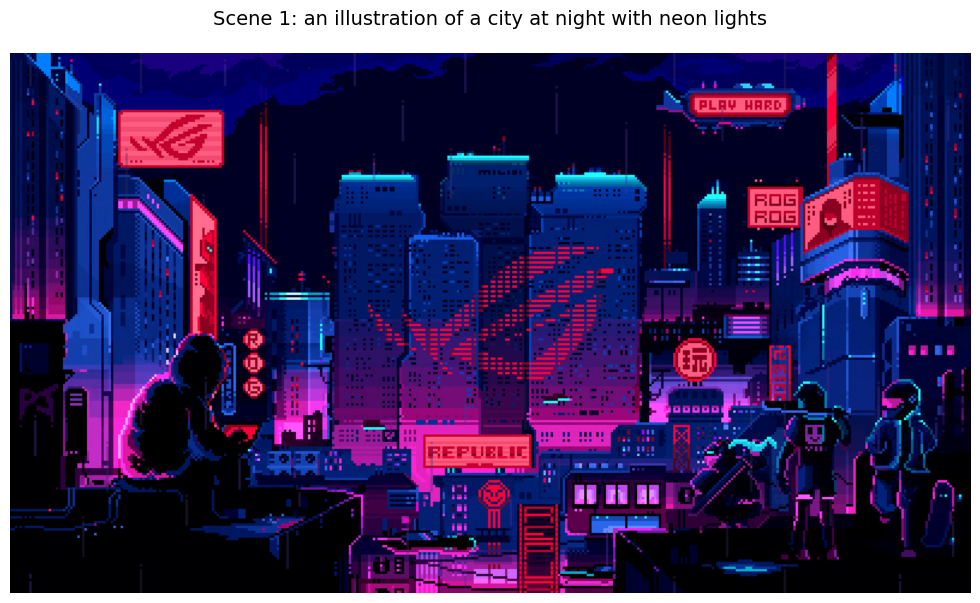

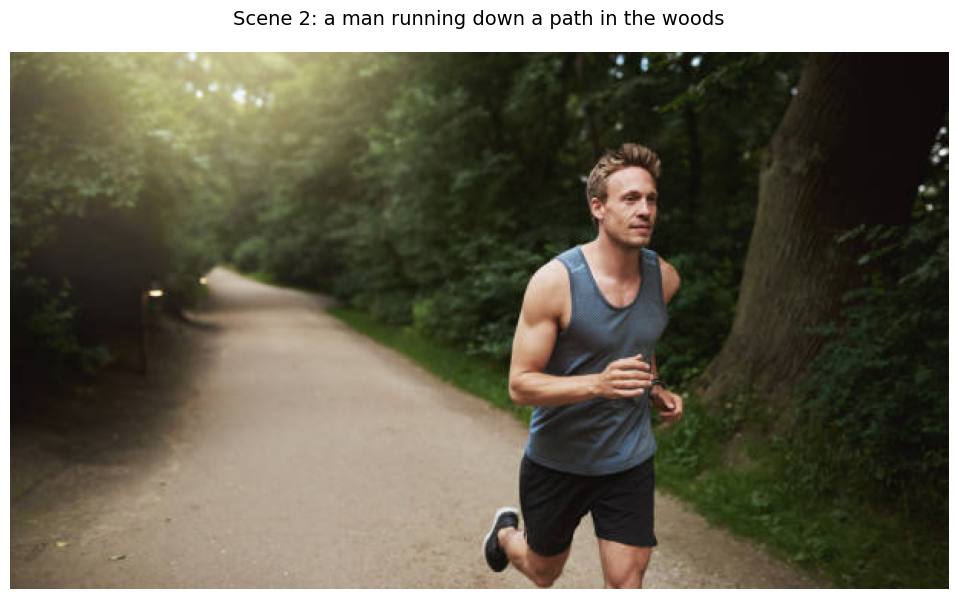

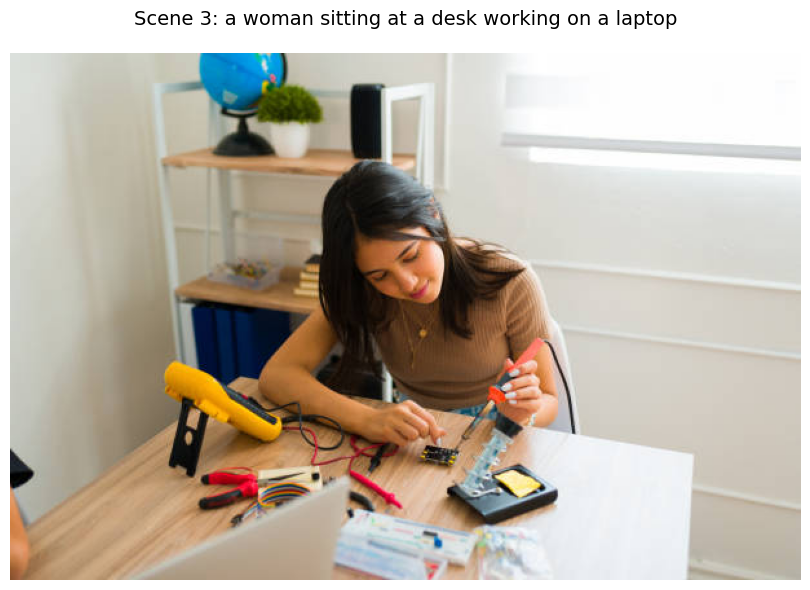

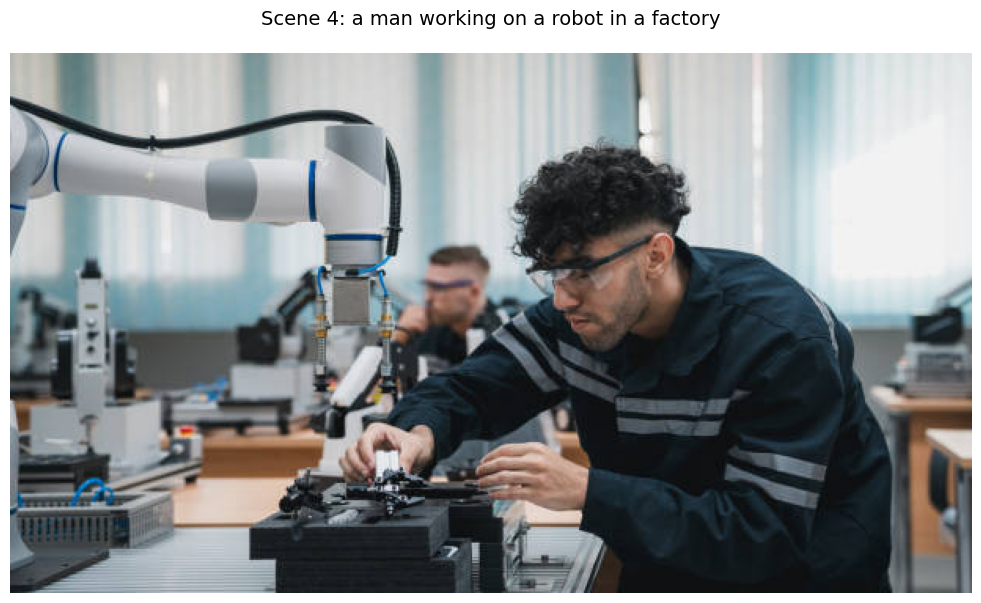

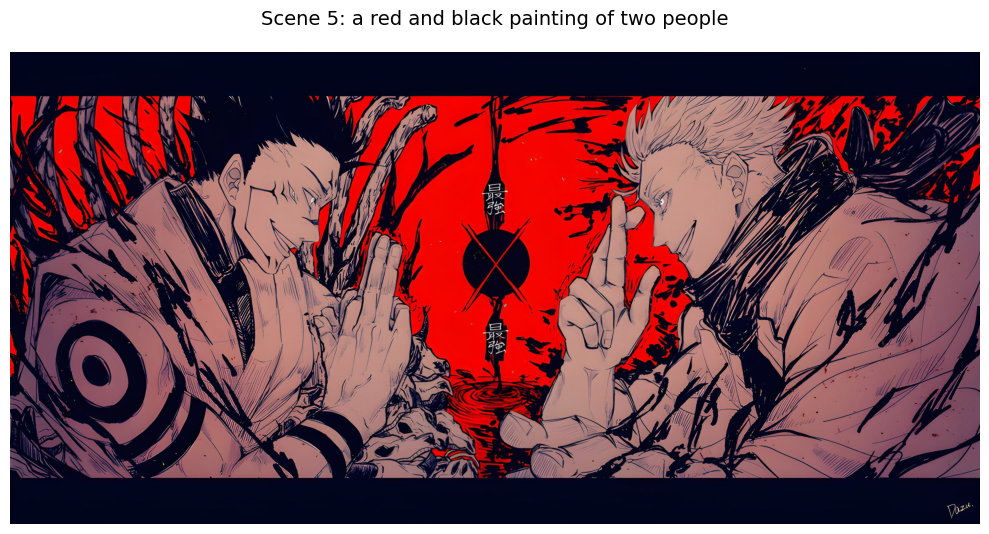

In [5]:
# =============================================================================
# CELL 5: PART 1 - Upload Images and Generate Captions
# =============================================================================
print("=" * 70)
print("PART 1: UPLOAD IMAGES & GENERATE CAPTIONS")
print("=" * 70)
print("\n📸 Please upload your images (recommended: 5-10 images)")
print("   Tip: Choose images that tell a sequence or story!")

# Upload images
uploaded = files.upload()

# Process images
images = []
image_names = []

for filename in uploaded.keys():
    try:
        image = Image.open(io.BytesIO(uploaded[filename])).convert('RGB')
        images.append(image)
        image_names.append(filename)
        print(f"✓ Loaded: {filename}")
    except Exception as e:
        print(f"✗ Error loading {filename}: {e}")

num_images = len(images)
print(f"\n✅ Successfully loaded {num_images} images!")

# Generate captions
print("\n🎯 Generating captions for your images...")
print("   This may take a moment...\n")

captions = []
for idx, image in enumerate(images):
    print(f"Processing image {idx + 1}/{num_images}...", end=" ")
    caption = generate_caption(image)
    captions.append(caption)
    print(f"✓ Done!")
    print(f"   Caption: '{caption}'\n")

print("✅ All captions generated!\n")

# Display all images with captions
print("=" * 70)
print("GENERATED CAPTIONS (IN ORDER)")
print("=" * 70)

for idx, (image, caption) in enumerate(zip(images, captions)):
    display_image_with_caption(image, caption, idx + 1)

In [6]:
# =============================================================================
# CELL 6: PART 2 - Review and Edit Captions
# =============================================================================
print("=" * 70)
print("PART 2: REVIEW & EDIT CAPTIONS")
print("=" * 70)
print(f"\n✅ {len(captions)} scenes ready for story generation!")
print("\nYour Scene Captions:")
print("-" * 70)

for idx, caption in enumerate(captions):
    print(f"Scene {idx + 1}: {caption}")

print("-" * 70)

display(HTML("""
<div style='background-color: #fff3cd; padding: 15px; border-radius: 5px;
            border-left: 4px solid #ffc107; margin: 20px 0;'>
    <strong>💡 Optional:</strong> Edit captions before generating the story!<br><br>
    Add a new cell below and modify captions like this:<br>
    <code>captions[0] = "A mysterious figure in the shadows"</code><br>
    <code>captions[2] = "An intense moment of revelation"</code>
</div>
"""))


PART 2: REVIEW & EDIT CAPTIONS

✅ 5 scenes ready for story generation!

Your Scene Captions:
----------------------------------------------------------------------
Scene 1: an illustration of a city at night with neon lights
Scene 2: a man running down a path in the woods
Scene 3: a woman sitting at a desk working on a laptop
Scene 4: a man working on a robot in a factory
Scene 5: a red and black painting of two people
----------------------------------------------------------------------


PART 3: SELECT MOOD & GENERATE STORY



📝 Enter your desired mood below:
   Options: romance, comedy, scary, action, cartoonish

✓ Selected mood: action

✨ Generating your action story from the captions...
   This may take 30-60 seconds...

✅ Story generation complete!



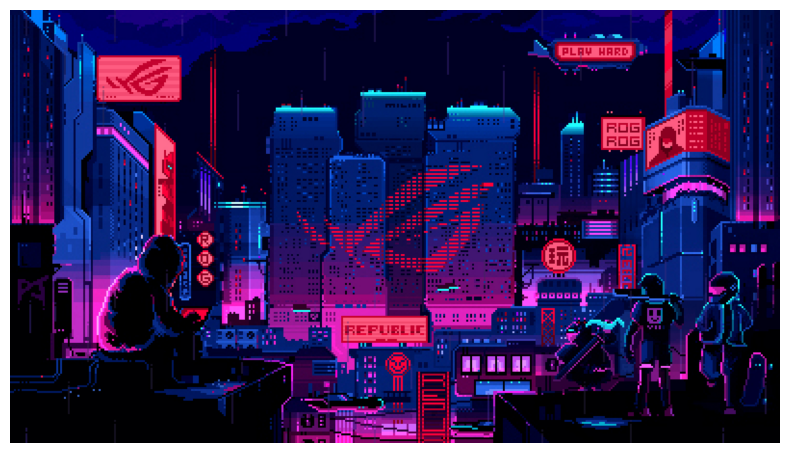

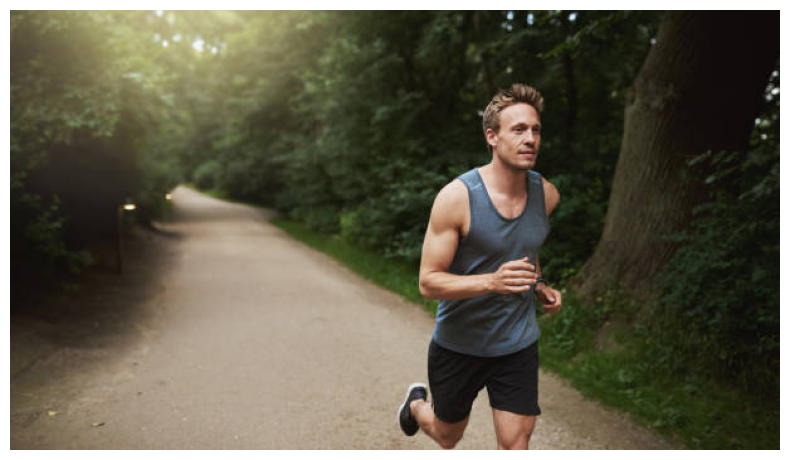

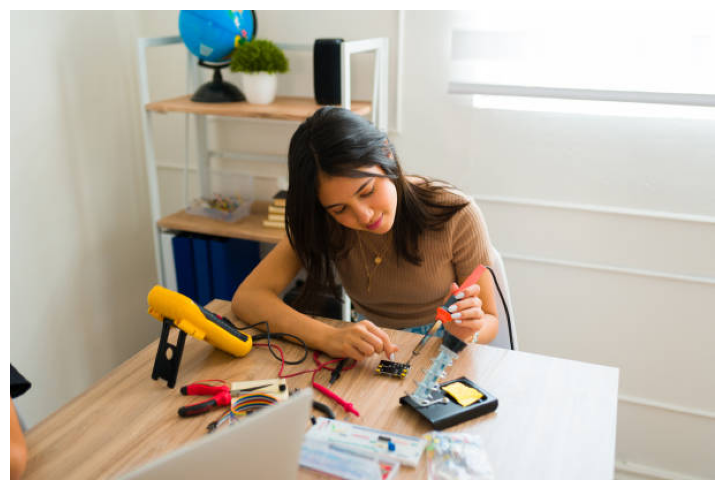

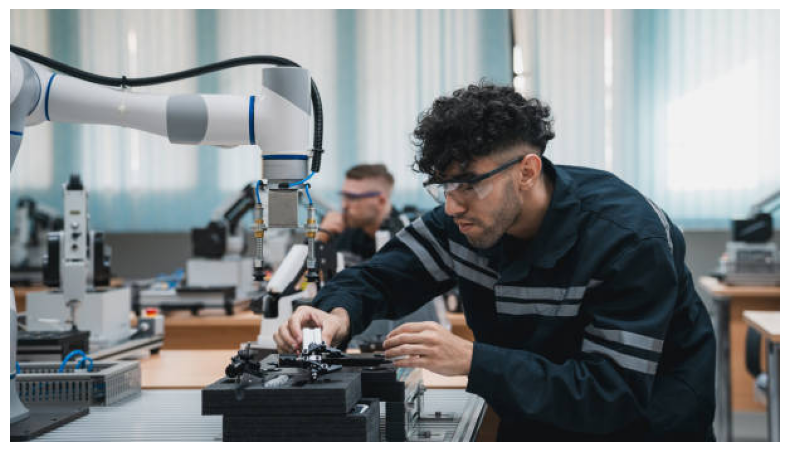

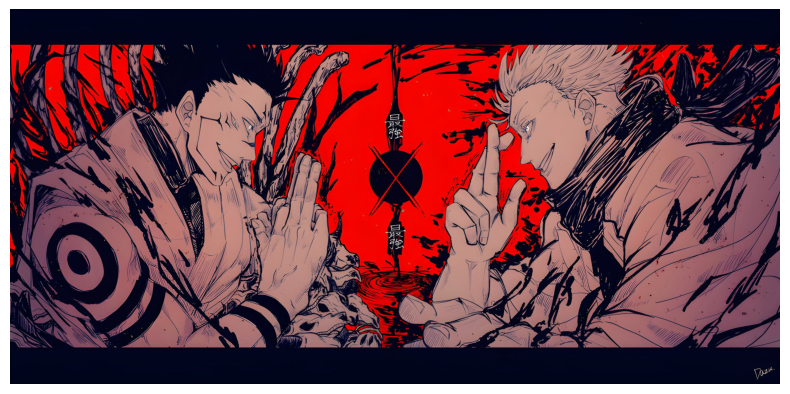


💾 Saving story to file...
✅ Story saved as 'generated_story.txt'

📥 Download it from the Files panel on the left



✨ PROJECT COMPLETE!

🎬 Your Action Storyboard is complete!
   Mood: Action
   Scenes: 5

💡 TIP: Run Cell 7 again to generate the same story in a different mood!

Thank you for using AI Storyboard Maker!


In [7]:
# =============================================================================
# CELL 7: PART 3 - Select Mood and Generate Story
# =============================================================================
print("=" * 70)
print("PART 3: SELECT MOOD & GENERATE STORY")
print("=" * 70)

# Display mood options
display(HTML("""
<div style='background-color: #e3f2fd; padding: 20px; border-radius: 10px; margin: 20px 0;'>
    <h3 style='color: #1976d2; margin-bottom: 15px;'>🎭 Choose Your Story Mood</h3>
    <p style='color: #424242; margin-bottom: 10px;'>Select one of the following moods for your story:</p>
    <ul style='color: #424242; line-height: 2;'>
        <li><strong>romance</strong> - Tender, emotional, heartfelt love story 💕</li>
        <li><strong>comedy</strong> - Funny, lighthearted, humorous tale 😄</li>
        <li><strong>scary</strong> - Dark, suspenseful horror story 😱</li>
        <li><strong>action</strong> - Fast-paced, thrilling adventure 💥</li>
        <li><strong>cartoonish</strong> - Whimsical, playful animated-style story 🎨</li>
    </ul>
</div>
"""))

print("\n📝 Enter your desired mood below:")
print("   Options: romance, comedy, scary, action, cartoonish")
print()

# Get mood from user
#story_mood = input("Enter mood (default: action): ").strip().lower()
story_mood = "action"

if not story_mood or story_mood not in ["romance", "comedy", "scary", "action", "cartoonish"]:
    story_mood = "action"
    print(f"⚠️  Invalid or empty input. Using default mood: action")
else:
    print(f"✓ Selected mood: {story_mood}")

print(f"\n✨ Generating your {story_mood} story from the captions...")
print("   This may take 30-60 seconds...\n")

# Generate the story
story = generate_story_from_captions(captions, mood=story_mood)

print("✅ Story generation complete!\n")

# Display the final result
display_story_with_scenes(story, images, captions, story_mood)

# Save story to file
print("\n💾 Saving story to file...")
with open('generated_story.txt', 'w', encoding='utf-8') as f:
    f.write(f"🎬 AI-GENERATED {story_mood.upper()} STORY\n")
    f.write("Generated using Gemma-2B\n")
    f.write("=" * 70 + "\n\n")
    f.write(story + "\n\n")
    f.write("=" * 70 + "\n")
    f.write("SCENE DESCRIPTIONS:\n")
    f.write("=" * 70 + "\n\n")
    for idx, caption in enumerate(captions):
        f.write(f"Scene {idx + 1}: {caption}\n")
    f.write(f"\nMood: {story_mood.title()}\n")

print(f"✅ Story saved as 'generated_story.txt'")
print("\n📥 Download it from the Files panel on the left")

# Display completion message
display(HTML(f"""
<div style='background-color: #d4edda; padding: 20px; border-radius: 5px;
            border-left: 4px solid #28a745; margin: 20px 0; text-align: center;'>
    <h3 style='color: #155724; margin-bottom: 10px;'>🎉 Your {story_mood.title()} Story is Ready!</h3>
    <p style='color: #155724;'>Check the 'generated_story.txt' file in the Files panel →</p>
    <p style='color: #155724; font-size: 14px; margin-top: 10px;'>
        ✨ Want a different mood? Just run Cell 7 again and choose another!
    </p>
</div>
"""))

print("\n" + "=" * 70)
print("✨ PROJECT COMPLETE!")
print("=" * 70)
print(f"\n🎬 Your {story_mood.title()} Storyboard is complete!")
print(f"   Mood: {story_mood.title()}")
print(f"   Scenes: {len(captions)}")
print("\n💡 TIP: Run Cell 7 again to generate the same story in a different mood!")
print("\nThank you for using AI Storyboard Maker!")